In [31]:
import pandas as pd
import numpy as np

precip = pd.read_csv("basin_averaged_climate_data/basin_total_precipitation.csv", index_col=0)
stream = pd.read_csv("combined_streamflow_cleaned.csv", index_col=0)

# Load metadata
meta = pd.read_csv("station_cluster_metadata.csv")

# Filter stations (non-glaciated == True)
non_glaciated_stations = meta.loc[meta["non-glaciated"] == True, "StationNum"].astype(str).tolist()

# Filter the precip/stream tables
precip = precip[non_glaciated_stations]
stream = stream[non_glaciated_stations]

print("Using stations:", non_glaciated_stations)


Using stations: ['05AB029', '05AD035', '05AE005', '05AH037', '05AH041', '05BK001', '05BM014', '05CB001', '05CB004', '05CC001', '05CC007', '05CC010', '05CD006', '05CE006', '05CE010', '05CE011', '05CE018', '05CG004', '05CK001', '05CK005', '05DF007', '05EA005', '05EC005', '05ED002', '05EE005', '05EE006', '05FA001', '05FB002', '05FC002', '05FE002', '07AH002', '07AH003', '07BB005', '07BC007', '07BF001', '07BF002', '07DA018', '07FD006', '07FD011', '07FD013', '07GD001', '07GE003', '07GF001', '07GG001', '07GG003', '07GH002', '07HA003', '07HA005', '07HF002', '07JC001', '07JD003', '07JF002', '07OA001', '07OB004', '07OB006']


In [ ]:
# use this if I only want one station

station_id = "05AE005"

precip_series = precip[station_id].values
stream_series = stream[station_id].values

In [20]:
N = 365  # lookback window

def create_dataset(X, y, N):
    X_out, y_out = [], []
    for i in range(len(X) - N - 1):
        X_out.append(X[i:i+N])
        y_out.append(y[i+N])
    return np.array(X_out), np.array(y_out)

X, y = create_dataset(precip_series, stream_series, N)

# reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))  # (samples, timesteps, features)


In [32]:
N = 365   # lookback window

def create_multi_station_dataset(precip_df, stream_df, N):
    X_all = []
    y_all = []

    for station in precip_df.columns:
        p = precip_df[station].values
        s = stream_df[station].values

        for i in range(len(p) - N - 1):
            X_all.append(p[i:i+N])
            y_all.append(s[i+N])

    X_all = np.array(X_all)
    y_all = np.array(y_all)
    
    # reshape for LSTM
    X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))
    return X_all, y_all

X, y = create_multi_station_dataset(precip, stream, N)
print("Dataset shape:", X.shape, y.shape)


Dataset shape: (843700, 365, 1) (843700,)


In [33]:
split1 = int(0.7 * len(X))
split2 = int(0.9 * len(X))

X_train, y_train = X[:split1], y[:split1]
X_val, y_val = X[split1:split2], y[split1:split2]
X_test, y_test = X[split2:], y[split2:]

In [34]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()

# reshape to 2D (samples, features)
X_train_2d = X_train.reshape(-1, 1)
X_val_2d   = X_val.reshape(-1, 1)
X_test_2d  = X_test.reshape(-1, 1)

X_train_scaled = scaler_x.fit_transform(X_train_2d).reshape(X_train.shape)
X_val_scaled   = scaler_x.transform(X_val_2d).reshape(X_val.shape)
X_test_scaled  = scaler_x.transform(X_test_2d).reshape(X_test.shape)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled   = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled  = scaler_y.transform(y_test.reshape(-1, 1))


In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.LSTM(80, return_sequences=False, input_shape=(N, 1)),
    layers.Dropout(0.1),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()


C:\Users\tbwil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 80)             │        26,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,321 (102.82 KB)

 Trainable params: 26,321 (102.82 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=5,
    batch_size=64
)


Epoch 1/5
 156/9228 ━━━━━━━━━━━━━━━━━━━━ 18:09 120ms/step - loss: 0.6639

KeyboardInterrupt: 

In [25]:
def nse(observed, simulated):
    """
    Nash–Sutcliffe Efficiency (NSE)
    """
    return 1 - np.sum((observed - simulated)**2) / np.sum((observed - np.mean(observed))**2)

# Predict validation period
y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)

# True values already in y_val (unscaled)
y_val_true = y_val

val_nse = nse(y_val_true, y_val_pred.flatten())
print("Validation NSE:", val_nse)

96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step
Validation NSE: 0.384776073996289


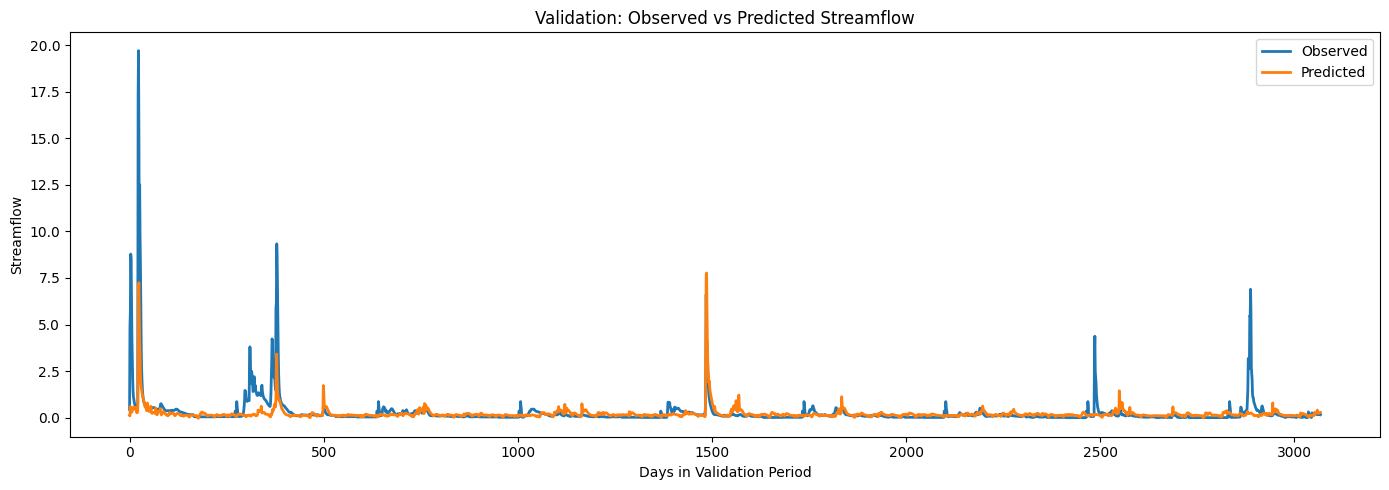

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_val_true, label="Observed", linewidth=2)
plt.plot(y_val_pred, label="Predicted", linewidth=2)
plt.title("Validation: Observed vs Predicted Streamflow")
plt.xlabel("Days in Validation Period")
plt.ylabel("Streamflow")
plt.legend()
plt.tight_layout()
plt.show()


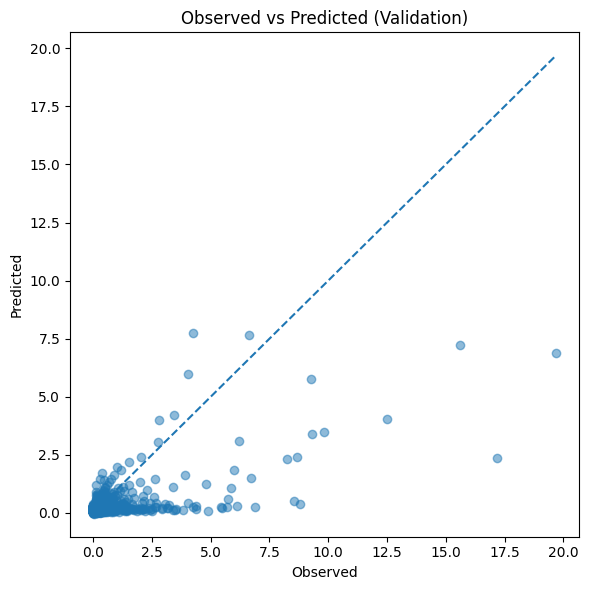

In [29]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val_true, y_val_pred, alpha=0.5)
plt.plot([min(y_val_true), max(y_val_true)],
         [min(y_val_true), max(y_val_true)], 
         linestyle="--")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Observed vs Predicted (Validation)")
plt.tight_layout()
plt.show()


# Create a proof-of-concept LSTM streamflow prediction model

### Load datasets

In [1]:
import pandas as pd
import numpy as np

maxT = pd.read_csv("basin_averaged_climate_data/basin_max_temperature.csv", index_col=0, parse_dates=True)[1:]
minT = pd.read_csv("basin_averaged_climate_data/basin_min_temperature.csv", index_col=0, parse_dates=True)[1:]
meanT = pd.read_csv("basin_averaged_climate_data/basin_mean_temperature.csv", index_col=0, parse_dates=True)[1:]
precip = pd.read_csv("basin_averaged_climate_data/basin_total_precipitation.csv", index_col=0, parse_dates=True)

stream = pd.read_csv("combined_streamflow_cleaned.csv", index_col=0, parse_dates=True)

meta = pd.read_csv("station_cluster_metadata.csv")

stations = meta["StationNum"].astype(str).tolist()


In [2]:
only_non_glaciated = False

if only_non_glaciated:
    meta = meta[meta["non-glaciated"] == True]
    stations = meta["StationNum"].astype(str).tolist()

    maxT = maxT[stations]
    minT = minT[stations]
    meanT = meanT[stations]
    precip = precip[stations]
    stream = stream[stations]


### Define the train/validation/test splits

| Set        | Years                 | Count           |
| ---------- | --------------------- | --------------- |
| Train      | 1988–2008             | 21 years (~50%) |
| Validation | 1984–1987             | 4 years (~10%)  |
| Test       | 1980–1983 + 2009–2022 | 18 years (~40%) |


In [3]:
years = stream.index.year

train_years = range(1988, 2009)
val_years   = range(1984, 1988)
test_years  = list(range(1980, 1984)) + list(range(2009, 2023))

train_mask = years.isin(train_years)
val_mask   = years.isin(val_years)
test_mask  = years.isin(test_years)

Split temporal datasets into train/validation/test by year

In [4]:
maxT_train, maxT_val, maxT_test = maxT[train_mask], maxT[val_mask], maxT[test_mask]
minT_train, minT_val, minT_test = minT[train_mask], minT[val_mask], minT[test_mask]
meanT_train, meanT_val, meanT_test = meanT[train_mask], meanT[val_mask], meanT[test_mask]
precip_train, precip_val, precip_test = precip[train_mask], precip[val_mask], precip[test_mask]
stream_train, stream_val, stream_test = stream[train_mask], stream[val_mask], stream[test_mask]
print("Train shape (days, stations):", maxT_train.shape)
print("Val shape (days, stations):", maxT_val.shape)
print("Test shape (days, stations):", maxT_test.shape)

Train shape (days, stations): (7671, 111)
Val shape (days, stations): (1461, 111)
Test shape (days, stations): (6574, 111)


Load in the static variables

In [5]:
static_features = meta.set_index("StationNum")[["Area_km2", "pct_glaciation"]]

Define the sequences

In [6]:
def build_sequences(maxT, minT, meanT, precip, stream, meta_static, N):
    X_seq = []
    X_static = []
    y = []

    for st in maxT.columns:
        seq1 = maxT[st].values
        seq2 = minT[st].values
        seq3 = meanT[st].values
        seq4 = precip[st].values
        out  = stream[st].values
        
        static = meta_static.loc[st].values.astype(float)

        for i in range(len(seq1) - N - 1):
            window = np.stack([
                seq1[i:i+N],
                seq2[i:i+N],
                seq3[i:i+N],
                seq4[i:i+N]
            ], axis=1)

            X_seq.append(window)
            X_static.append(static)
            y.append(out[i+N])
    
    return np.array(X_seq), np.array(X_static), np.array(y)


In [13]:
N = 365

Xseq_train, Xstat_train, y_train = build_sequences(
    maxT_train, minT_train, meanT_train, precip_train, stream_train, static_features, N
)

Xseq_val, Xstat_val, y_val = build_sequences(
    maxT_val, minT_val, meanT_val, precip_val, stream_val, static_features, N
)

Xseq_test, Xstat_test, y_test = build_sequences(
    maxT_test, minT_test, meanT_test, precip_test, stream_test, static_features, N
)

MemoryError: Unable to allocate 7.50 GiB for an array with shape (689088, 365, 4) and data type float64

In [ ]:
Xseq_val.shape, Xstat_val.shape, y_val.shape

((121545, 365, 4), (121545, 2), 1095.0)

In [ ]:
from sklearn.preprocessing import StandardScaler

sc_y = StandardScaler()
y_train_scaled = sc_y.fit_transform(y_train.reshape(-1,1))
y_val_scaled   = sc_y.transform(y_val.reshape(-1,1))
y_test_scaled  = sc_y.transform(y_test.reshape(-1,1))

sc_static = StandardScaler()
Xstat_train_scaled = sc_static.fit_transform(Xstat_train)
Xstat_val_scaled   = sc_static.transform(Xstat_val)
Xstat_test_scaled  = sc_static.transform(Xstat_test)

sc_seq = StandardScaler()
Xseq_train_scaled = sc_seq.fit_transform(Xseq_train.reshape(-1,4)).reshape(Xseq_train.shape)
Xseq_val_scaled   = sc_seq.transform(Xseq_val.reshape(-1,4)).reshape(Xseq_val.shape)
Xseq_test_scaled  = sc_seq.transform(Xseq_test.reshape(-1,4)).reshape(Xseq_test.shape)


### Trying again

In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

In [34]:
climate = {
    "tmax": pd.read_csv("basin_averaged_climate_data/basin_max_temperature.csv", index_col=0, parse_dates=True)[1:],
    "tmean": pd.read_csv("basin_averaged_climate_data/basin_mean_temperature.csv", index_col=0, parse_dates=True)[1:],
    "tmin": pd.read_csv("basin_averaged_climate_data/basin_min_temperature.csv", index_col=0, parse_dates=True)[1:],
    "ppt": pd.read_csv("basin_averaged_climate_data/basin_total_precipitation.csv", index_col=0, parse_dates=True)
}

meta = pd.read_csv("station_cluster_metadata.csv")
meta["StationNum"] = meta["StationNum"].astype(str)

In [35]:
dates = climate["tmax"].index
years = pd.Series(dates.year)

unique_years = sorted(years.unique())
n = len(unique_years)

val_years   = unique_years[: int(n*0.10)]
train_years = unique_years[int(n*0.10): int(n*0.60)]
test_years  = unique_years[int(n*0.60):]

def year_mask(allowed_years):
    return years.isin(allowed_years).values

train_mask = year_mask(train_years)
val_mask   = year_mask(val_years)
test_mask  = year_mask(test_years)


In [36]:
scalers = {}

for var in ["tmax", "tmean", "tmin", "ppt"]:
    arr = climate[var].values[train_mask, :].astype("float32")
    flat = arr.flatten()
    mean, std = np.nanmean(flat), np.nanstd(flat)
    scalers[var] = (mean, std)

    # Apply to all data, downcast to float16
    climate[var] = ((climate[var] - mean) / (std + 1e-6)).astype("float16")


In [37]:
train_stations = climate["tmax"].columns

# take the log of area to reduce skew
meta["area_log"] = np.log1p(meta["Area_km2"])

area_mean = meta.loc[meta["StationNum"].isin(train_stations), "area_log"].mean()
area_std  = meta.loc[meta["StationNum"].isin(train_stations), "area_log"].std()

glac_mean = meta.loc[meta["StationNum"].isin(train_stations), "pct_glaciation"].mean()
glac_std  = meta.loc[meta["StationNum"].isin(train_stations), "pct_glaciation"].std()

meta["Area_norm"] = ((meta["area_log"] - area_mean) / (area_std + 1e-6)).astype("float16")
meta["Glac_norm"] = ((meta["pct_glaciation"] - glac_mean) / (glac_std + 1e-6)).astype("float16")


In [38]:
entity_dict = {}
for _, row in meta.iterrows():
    entity_dict[str(row["StationNum"])] = np.array(
        [row["Area_norm"], row["Glac_norm"]],
        dtype="float16"
    )

In [39]:
def generator(climate, streamflow_df, station_list, mask, seq_len=365, batch_size=64):
    X_clim, X_static, Y = [], [], []
    count = 0

    for station in station_list:
        sf = streamflow_df[station].values.astype("float16")
        tmax = climate["tmax"][station].values
        tmean = climate["tmean"][station].values
        tmin = climate["tmin"][station].values
        ppt = climate["ppt"][station].values

        ent = entity_dict[station]

        for i in range(len(sf) - seq_len - 1):
            if not mask[i + seq_len]:  
                continue

            x = np.stack([
                tmax[i:i+seq_len],
                tmean[i:i+seq_len],
                tmin[i:i+seq_len],
                ppt[i:i+seq_len]
            ], axis=1)  # (365, 4)

            X_clim.append(x.astype("float16"))
            X_static.append(ent)
            Y.append(sf[i+seq_len].astype("float16"))

            count += 1
            if count == batch_size:
                yield (
                    [np.array(X_clim, dtype="float16"),
                     np.array(X_static, dtype="float16")],
                    np.array(Y, dtype="float16")
                )
                X_clim, X_static, Y = [], [], []
                count = 0

    if count > 0:
        yield (
            [np.array(X_clim, dtype="float16"),
             np.array(X_static, dtype="float16")],
            np.array(Y, dtype="float16")
        )


In [48]:
def build_model(seq_len=365, feat_dim=4, static_dim=2, lstm_units=80):
    # Time‐varying input
    inp_seq = layers.Input(shape=(seq_len, feat_dim), dtype="float16")
    x = layers.LSTM(lstm_units, return_sequences=False)(inp_seq)

    # Static features
    inp_static = layers.Input(shape=(static_dim,), dtype="float16")

    # Combine
    z = layers.Concatenate()([x, inp_static])
    z = layers.Dense(64, activation="relu")(z)
    out = layers.Dense(1)(z)

    return Model([inp_seq, inp_static], out)

model = build_model()
model.compile(optimizer="adam", loss="mse")
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 365, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 80)        │     27,200 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 82)        │          0 │ lstm_4[0][0],     │
│ (Concatenate)       │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      5,312 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,577 (127.25 KB)

 Trainable params: 32,577 (127.25 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
import tensorflow as tf

# -----------------------------
# 1. Get station list & align
# -----------------------------
station_list = climate["tmax"].columns
streamflow_df = pd.read_csv("combined_streamflow_cleaned.csv", 
                            index_col=0, parse_dates=True)
streamflow_df = streamflow_df[station_list]  # ensure matching stations

batch_size = 64
input_length = 365
num_vars = len(climate)    # e.g. tmax, tmin, precip, etc.
num_stations = len(station_list)

# -----------------------------
# 2. Wrap Python generator
# -----------------------------
train_ds = tf.data.Dataset.from_generator(
    lambda: generator(climate, streamflow_df, station_list, train_mask, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, input_length, num_vars), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size, num_stations), dtype=tf.float32)
    )
)

val_ds = tf.data.Dataset.from_generator(
    lambda: generator(climate, streamflow_df, station_list, val_mask, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, input_length, num_vars), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size, num_stations), dtype=tf.float32)
    )
)

# -----------------------------
# 3. Train
# -----------------------------
steps_train = 2000
steps_val   = 300

history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=steps_train,
    validation_steps=steps_val,
    epochs=20
)

Epoch 1/20


ValueError: Layer "functional_3" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(64, 365, 4) dtype=float32>]

In [50]:
model.inputs

[<KerasTensor shape=(None, 365, 4), dtype=float16, sparse=False, name=keras_tensor_26>,
 <KerasTensor shape=(None, 2), dtype=float16, sparse=False, name=keras_tensor_28>]

# Trying yet again

In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import os
from datetime import datetime
import pickle

# Configuration
SEQ_LENGTH = 365
LSTM_UNITS = 80
BATCH_SIZE = 32
CHUNK_SIZE = 5  # Process 50 stations at a time
STATIC_FEATURES = ['pct_glaciation', 'log_area']
DYNAMIC_FEATURES = ['max_temp', 'min_temp', 'precip', 'mean_temp']

class ChunkedDataProcessor:
    """Process large datasets in chunks to avoid memory issues"""
    
    def __init__(self, seq_length=365):
        self.seq_length = seq_length
        self.scalers = {
            'dynamic': StandardScaler(),
            'static': StandardScaler(),
            'target': StandardScaler()
        }
        
    def load_and_prepare_data(self):
        """Load all data files and prepare metadata"""
        print("Loading data files...")
        
        # Load climate data
        max_temp = pd.read_csv('basin_averaged_climate_data/basin_max_temperature.csv', 
                               index_col=0, parse_dates=True)
        min_temp = pd.read_csv('basin_averaged_climate_data/basin_min_temperature.csv',
                               index_col=0, parse_dates=True)
        precip = pd.read_csv('basin_averaged_climate_data/basin_total_precipitation.csv',
                            index_col=0, parse_dates=True)
        mean_temp = pd.read_csv('basin_averaged_climate_data/basin_mean_temperature.csv',
                               index_col=0, parse_dates=True)
        
        # Load target data
        streamflow = pd.read_csv('combined_streamflow_cleaned.csv',
                                index_col=0, parse_dates=True)
        
        # Load static features
        metadata = pd.read_csv('station_cluster_metadata.csv')
        metadata['log_area'] = np.log(metadata['Area_km2'])
        
        # Align all datasets
        common_dates = max_temp.index.intersection(min_temp.index)\
                                      .intersection(precip.index)\
                                      .intersection(mean_temp.index)\
                                      .intersection(streamflow.index)
        common_stations = list(set(max_temp.columns) & 
                              set(min_temp.columns) & 
                              set(precip.columns) & 
                              set(mean_temp.columns) &
                              set(streamflow.columns) &
                              set(metadata['StationNum'].astype(str)))
        
        print(f"Found {len(common_dates)} common dates and {len(common_stations)} stations")
        
        # Sort and filter
        common_dates = sorted(common_dates)
        max_temp = max_temp.loc[common_dates, common_stations].astype(np.float16)
        min_temp = min_temp.loc[common_dates, common_stations].astype(np.float16)
        precip = precip.loc[common_dates, common_stations].astype(np.float16)
        mean_temp = mean_temp.loc[common_dates, common_stations].astype(np.float16)
        streamflow = streamflow.loc[common_dates, common_stations].astype(np.float16)
        
        metadata = metadata[metadata['StationNum'].astype(str).isin(common_stations)]
        metadata = metadata.set_index('StationNum')
        metadata = metadata.loc[[int(s) if s.isdigit() else s for s in common_stations]]
        
        return {
            'max_temp': max_temp,
            'min_temp': min_temp,
            'precip': precip,
            'mean_temp': mean_temp,
            'streamflow': streamflow,
            'metadata': metadata,
            'dates': common_dates,
            'stations': common_stations
        }
    
    def create_temporal_splits(self, dates):
        """Create train/val/test splits preserving year boundaries"""
        df_dates = pd.DataFrame({'date': dates})
        df_dates['year'] = df_dates['date'].dt.year
        
        years = sorted(df_dates['year'].unique())
        n_years = len(years)
        
        # Split years: 50/10/40
        train_years = years[:int(0.5 * n_years)]
        val_years = years[int(0.5 * n_years):int(0.6 * n_years)]
        test_years = years[int(0.6 * n_years):]
        
        train_mask = df_dates['year'].isin(train_years).values
        val_mask = df_dates['year'].isin(val_years).values
        test_mask = df_dates['year'].isin(test_years).values
        
        print(f"Train years: {train_years[0]}-{train_years[-1]} ({len(train_years)} years)")
        print(f"Val years: {val_years[0]}-{val_years[-1]} ({len(val_years)} years)")
        print(f"Test years: {test_years[0]}-{test_years[-1]} ({len(test_years)} years)")
        
        return train_mask, val_mask, test_mask
    
    def fit_scalers(self, data_dict, train_mask):
        """Fit scalers on training data"""
        print("Fitting scalers on training data...")
        
        # Fit dynamic scaler (on flattened training data)
        dynamic_train = []
        for feat in DYNAMIC_FEATURES:
            if feat == 'max_temp':
                dynamic_train.append(data_dict['max_temp'].values[train_mask].flatten())
            elif feat == 'min_temp':
                dynamic_train.append(data_dict['min_temp'].values[train_mask].flatten())
            elif feat == 'precip':
                dynamic_train.append(data_dict['precip'].values[train_mask].flatten())
            elif feat == 'mean_temp':
                dynamic_train.append(data_dict['mean_temp'].values[train_mask].flatten())
        
        dynamic_train = np.column_stack(dynamic_train).astype(np.float32)
        dynamic_train = dynamic_train[~np.isnan(dynamic_train).any(axis=1)]
        self.scalers['dynamic'].fit(dynamic_train)
        
        # Fit static scaler
        static_data = data_dict['metadata'][STATIC_FEATURES].values.astype(np.float32)
        self.scalers['static'].fit(static_data)
        
        # Fit target scaler
        target_train = data_dict['streamflow'].values[train_mask].flatten()
        target_train = target_train[~np.isnan(target_train)].reshape(-1, 1).astype(np.float32)
        self.scalers['target'].fit(target_train)
        
        print("Scalers fitted successfully")
    
    def create_sequences_chunked(self, data_dict, mask, station_chunk):
        """Create sequences for a chunk of stations"""
        stations = data_dict['stations']
        chunk_stations = stations[station_chunk[0]:station_chunk[1]]
        
        X_dynamic_list = []
        X_static_list = []
        y_list = []
        
        for station in chunk_stations:
            # Extract data for this station
            station_data = np.column_stack([
                data_dict['max_temp'][station].values,
                data_dict['min_temp'][station].values,
                data_dict['precip'][station].values,
                data_dict['mean_temp'][station].values
            ]).astype(np.float32)
            
            target = data_dict['streamflow'][station].values.astype(np.float32)
            
            # Apply mask
            station_data = station_data[mask]
            target = target[mask]
            
            # Normalize
            station_data = self.scalers['dynamic'].transform(station_data).astype(np.float16)
            target = self.scalers['target'].transform(target.reshape(-1, 1)).astype(np.float16)
            
            # Create sequences
            for i in range(len(station_data) - self.seq_length):
                X_dynamic_list.append(station_data[i:i+self.seq_length])
                y_list.append(target[i+self.seq_length])
                
                # Static features (same for all sequences of this station)
                static_idx = data_dict['metadata'].index.get_loc(
                    int(station) if station.isdigit() else station
                )
                static_feat = data_dict['metadata'].iloc[static_idx][STATIC_FEATURES].values
                static_feat = self.scalers['static'].transform(static_feat.reshape(1, -1))
                X_static_list.append(static_feat[0].astype(np.float16))
        
        return (np.array(X_dynamic_list, dtype=np.float16),
                np.array(X_static_list, dtype=np.float16),
                np.array(y_list, dtype=np.float16))
    
    def prepare_dataset(self, data_dict, mask, chunk_size=CHUNK_SIZE):
        """Prepare dataset by processing stations in chunks"""
        n_stations = len(data_dict['stations'])
        n_chunks = (n_stations + chunk_size - 1) // chunk_size
        
        X_dynamic_all = []
        X_static_all = []
        y_all = []
        
        for chunk_idx in range(n_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = min((chunk_idx + 1) * chunk_size, n_stations)
            
            print(f"Processing chunk {chunk_idx+1}/{n_chunks} (stations {start_idx}-{end_idx})")
            
            X_dyn, X_stat, y = self.create_sequences_chunked(
                data_dict, mask, (start_idx, end_idx)
            )
            
            X_dynamic_all.append(X_dyn)
            X_static_all.append(X_stat)
            y_all.append(y)
            
            # Clear memory
            del X_dyn, X_stat, y
        
        X_dynamic = np.concatenate(X_dynamic_all, axis=0)
        X_static = np.concatenate(X_static_all, axis=0)
        y = np.concatenate(y_all, axis=0)
        
        print(f"Created {len(X_dynamic)} sequences")
        
        return X_dynamic, X_static, y

def create_ea_lstm_model(seq_length, n_dynamic_features, n_static_features, lstm_units=80):
    """Create Entity-Aware LSTM model"""
    
    # Dynamic input (time series)
    dynamic_input = keras.Input(shape=(seq_length, n_dynamic_features), name='dynamic_input')
    
    # Static input (entity features)
    static_input = keras.Input(shape=(n_static_features,), name='static_input')
    
    # Process static features
    static_encoded = keras.layers.Dense(32, activation='relu')(static_input)
    static_encoded = keras.layers.Dense(16, activation='relu')(static_encoded)
    
    # LSTM processing
    lstm_out = keras.layers.LSTM(lstm_units, return_sequences=False)(dynamic_input)
    
    # Combine LSTM output with static features
    combined = keras.layers.Concatenate()([lstm_out, static_encoded])
    
    # Output layers
    x = keras.layers.Dense(64, activation='relu')(combined)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    output = keras.layers.Dense(1, name='streamflow_output')(x)
    
    model = keras.Model(
        inputs=[dynamic_input, static_input],
        outputs=output,
        name='EA_LSTM_Streamflow'
    )
    
    return model

# Main execution
if __name__ == "__main__":
    print("="*50)
    print("Entity-Aware LSTM for Streamflow Prediction")
    print("="*50)
    
    # Initialize processor
    processor = ChunkedDataProcessor(seq_length=SEQ_LENGTH)
    
    # Load data
    data_dict = processor.load_and_prepare_data()
    
    # Create temporal splits
    train_mask, val_mask, test_mask = processor.create_temporal_splits(data_dict['dates'])
    
    # Fit scalers on training data
    processor.fit_scalers(data_dict, train_mask)
    
    # Save scalers
    with open('scalers.pkl', 'wb') as f:
        pickle.dump(processor.scalers, f)
    print("Scalers saved to scalers.pkl")
    
    # Prepare datasets
    print("\nPreparing training data...")
    X_train_dyn, X_train_stat, y_train = processor.prepare_dataset(data_dict, train_mask)
    
    print("\nPreparing validation data...")
    X_val_dyn, X_val_stat, y_val = processor.prepare_dataset(data_dict, val_mask)
    
    print("\nPreparing test data...")
    X_test_dyn, X_test_stat, y_test = processor.prepare_dataset(data_dict, test_mask)
    
    # Create model
    print("\nCreating model...")
    model = create_ea_lstm_model(
        seq_length=SEQ_LENGTH,
        n_dynamic_features=len(DYNAMIC_FEATURES),
        n_static_features=len(STATIC_FEATURES),
        lstm_units=LSTM_UNITS
    )
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    print(model.summary())
    
    # Train model
    print("\nTraining model...")
    history = model.fit(
        [X_train_dyn, X_train_stat],
        y_train,
        validation_data=([X_val_dyn, X_val_stat], y_val),
        epochs=5,
        batch_size=BATCH_SIZE,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5),
            keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
        ],
        verbose=1
    )
    
    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_loss, test_mae = model.evaluate([X_test_dyn, X_test_stat], y_test)
    print(f"Test MSE: {test_loss:.6f}")
    print(f"Test MAE: {test_mae:.6f}")
    
    # Make predictions
    predictions = model.predict([X_test_dyn, X_test_stat])
    
    # Inverse transform predictions
    predictions_original = processor.scalers['target'].inverse_transform(predictions)
    y_test_original = processor.scalers['target'].inverse_transform(y_test)
    
    print("\nModel training complete!")
    print(f"Model saved to: best_model.keras")
    print(f"Scalers saved to: scalers.pkl")

Entity-Aware LSTM for Streamflow Prediction
Loading data files...
Found 15706 common dates and 111 stations
Train years: 1980-2000 (21 years)
Val years: 2001-2004 (4 years)
Test years: 2005-2022 (18 years)
Fitting scalers on training data...
Scalers fitted successfully
Scalers saved to scalers.pkl

Preparing training data...
Processing chunk 1/23 (stations 0-5)
Processing chunk 2/23 (stations 5-10)
Processing chunk 3/23 (stations 10-15)
Processing chunk 4/23 (stations 15-20)
Processing chunk 5/23 (stations 20-25)
Processing chunk 6/23 (stations 25-30)
Processing chunk 7/23 (stations 30-35)
Processing chunk 8/23 (stations 35-40)
Processing chunk 9/23 (stations 40-45)
Processing chunk 10/23 (stations 45-50)
Processing chunk 11/23 (stations 50-55)
Processing chunk 12/23 (stations 55-60)
Processing chunk 13/23 (stations 60-65)
Processing chunk 14/23 (stations 65-70)
Processing chunk 15/23 (stations 70-75)
Processing chunk 16/23 (stations 75-80)
Processing chunk 17/23 (stations 80-85)
Proce

Model: "EA_LSTM_Streamflow"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ static_input        │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dynamic_input       │ (None, 365, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_6 (Cast)       │ (None, 2)         │          0 │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_7 (Cast)       │ (None, 365, 4)    │          0 │ dynamic_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │         96 │ cast_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 80)        │     27,200 │ cast_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 16)        │        528 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 96)        │          0 │ lstm_5[0][0],     │
│ (Concatenate)       │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      6,208 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ streamflow_output   │ (None, 1)         │         33 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,145 (141.19 KB)

 Trainable params: 36,145 (141.19 KB)

 Non-trainable params: 0 (0.00 B)

None

Training model...
Epoch 1/5


C:\Users\tbwil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['dynamic_input', 'static_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


25343/25343 ━━━━━━━━━━━━━━━━━━━━ 4450s 175ms/step - loss: 0.2444 - mae: 0.1300 - val_loss: 0.0894 - val_mae: 0.1685 - learning_rate: 0.0010
Epoch 2/5
25343/25343 ━━━━━━━━━━━━━━━━━━━━ 4426s 175ms/step - loss: 0.1248 - mae: 0.0940 - val_loss: 0.1086 - val_mae: 0.1634 - learning_rate: 0.0010
Epoch 3/5
25343/25343 ━━━━━━━━━━━━━━━━━━━━ 4575s 181ms/step - loss: 0.0964 - mae: 0.0873 - val_loss: 0.0863 - val_mae: 0.1782 - learning_rate: 0.0010
Epoch 4/5
25343/25343 ━━━━━━━━━━━━━━━━━━━━ 4422s 174ms/step - loss: 0.0812 - mae: 0.0830 - val_loss: 0.0829 - val_mae: 0.1844 - learning_rate: 0.0010
Epoch 5/5
25343/25343 ━━━━━━━━━━━━━━━━━━━━ 4424s 175ms/step - loss: 0.0754 - mae: 0.0794 - val_loss: 0.0734 - val_mae: 0.1824 - learning_rate: 0.0010

Evaluating on test set...
21538/21538 ━━━━━━━━━━━━━━━━━━━━ 1592s 74ms/step - loss: 0.2103 - mae: 0.2117
Test MSE: 0.183292
Test MAE: 0.197560
21538/21538 ━━━━━━━━━━━━━━━━━━━━ 1585s 74ms/step

Model training complete!
Model saved to: best_model.keras
Scalers s

Loading model and scalers...
Loading climate + streamflow data...
{'dynamic': StandardScaler(), 'static': StandardScaler(), 'target': StandardScaler()}
Preparing evaluation data for station 07DA001, year 1988...


C:\Users\tbwil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['dynamic_input', 'static_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


NSE for station 07DA001, 1988 = 0.948


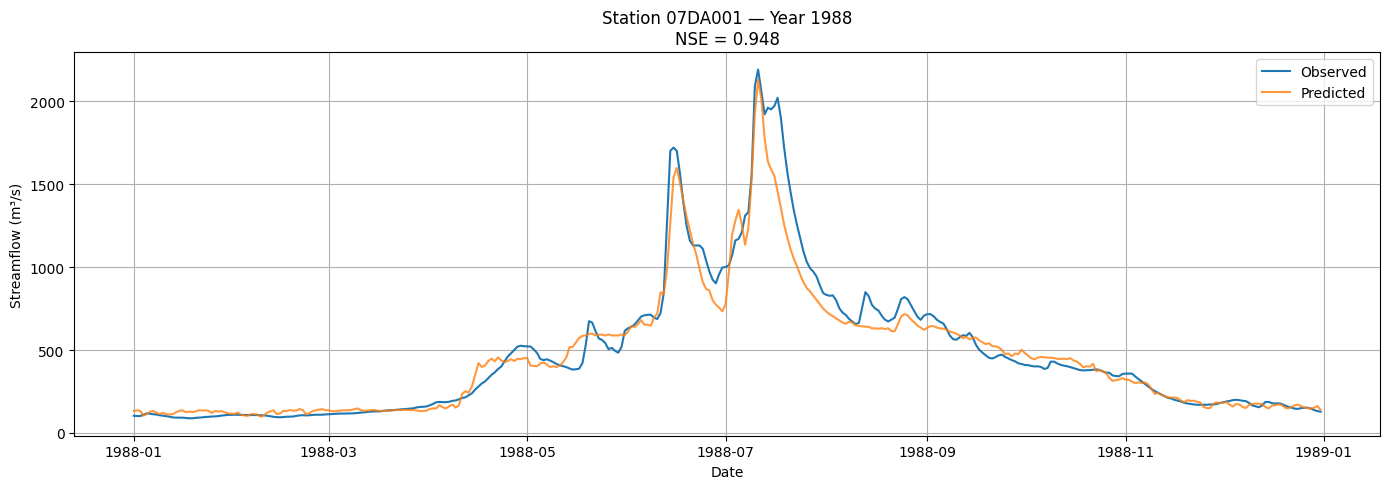

In [94]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import pickle
import matplotlib.pyplot as plt

from datetime import datetime

SEQ_LENGTH = 365
DYNAMIC_FEATURES = ['max_temp', 'min_temp', 'precip', 'mean_temp']
STATIC_FEATURES = ['pct_glaciation', 'log_area']

# -------------------------------------------------------------------
# Helper function: Nash–Sutcliffe Efficiency
# -------------------------------------------------------------------
def nse(obs, sim):
    return 1 - np.sum((sim - obs)**2) / np.sum((obs - np.mean(obs))**2)

# -------------------------------------------------------------------
# Load training scalers, model, and data
# -------------------------------------------------------------------
def load_everything():
    print("Loading model and scalers...")
    model = keras.models.load_model("best_model.keras")

    with open("scalers.pkl", "rb") as f:
        scalers = pickle.load(f)

    print("Loading climate + streamflow data...")
    max_temp = pd.read_csv('basin_averaged_climate_data/basin_max_temperature.csv', index_col=0, parse_dates=True)
    min_temp = pd.read_csv('basin_averaged_climate_data/basin_min_temperature.csv', index_col=0, parse_dates=True)
    precip = pd.read_csv('basin_averaged_climate_data/basin_total_precipitation.csv', index_col=0, parse_dates=True)
    mean_temp = pd.read_csv('basin_averaged_climate_data/basin_mean_temperature.csv', index_col=0, parse_dates=True)
    streamflow = pd.read_csv('combined_streamflow_cleaned.csv', index_col=0, parse_dates=True)

    metadata = pd.read_csv("station_cluster_metadata.csv")
    metadata['log_area'] = np.log(metadata['Area_km2'])
    metadata = metadata.set_index("StationNum")

    # Align stations
    stations = list(
        set(max_temp.columns)
        & set(min_temp.columns)
        & set(precip.columns)
        & set(mean_temp.columns)
        & set(streamflow.columns)
        & set(metadata.index.astype(str))
    )
    stations = sorted(stations)

    return model, scalers, {
        "max_temp": max_temp[stations],
        "min_temp": min_temp[stations],
        "precip": precip[stations],
        "mean_temp": mean_temp[stations],
        "streamflow": streamflow[stations],
        "metadata": metadata.loc[[s for s in stations]],
        "stations": stations
    }

# -------------------------------------------------------------------
# Build 365-day evaluation sequences for a station + year
# -------------------------------------------------------------------
def build_eval_sequences(station, year, scalers, data):
    print(f"Preparing evaluation data for station {station}, year {year}...")

    df = pd.DataFrame({
        "max_temp": data["max_temp"][station],
        "min_temp": data["min_temp"][station],
        "precip": data["precip"][station],
        "mean_temp": data["mean_temp"][station],
        "streamflow": data["streamflow"][station]
    })

    # df = df.loc[df.index.year == year]
    start_index = df.index.searchsorted(datetime(year, 1, 1))
    end_index = df.index.searchsorted(datetime(year + 1, 1, 1))

    # if len(df) < SEQ_LENGTH + 1:
    #     raise ValueError(f"Not enough data in {year} for station {station}")

    # Dynamic features
    X_dyn = df[DYNAMIC_FEATURES].values.astype(np.float32)
    X_dyn_scaled = scalers["dynamic"].transform(X_dyn)

    # Target
    y = df["streamflow"].values.astype(np.float32)
    y_scaled = scalers["target"].transform(y.reshape(-1, 1)).flatten()

    # Static features
    static_feat = data["metadata"].loc[station][STATIC_FEATURES].values.reshape(1, -1)
    static_scaled = scalers["static"].transform(static_feat)[0]

    # Build sequences
    dyn_seq = []
    stat_seq = []
    y_seq = []

    for i in range(start_index, end_index):
        dyn_seq.append(X_dyn_scaled[i - SEQ_LENGTH:i])
        stat_seq.append(static_scaled)
        y_seq.append(y_scaled[i])

    return (
        np.array(dyn_seq, dtype=np.float32),
        np.array(stat_seq, dtype=np.float32),
        np.array(y_seq, dtype=np.float32),
        df.index[start_index:end_index]
    )

# -------------------------------------------------------------------
# Plot observed vs predicted
# -------------------------------------------------------------------
def plot_results(dates, obs, pred, station, year, nse_value):
    plt.figure(figsize=(14,5))
    plt.plot(dates, obs, label="Observed")
    plt.plot(dates, pred, label="Predicted", alpha=0.8)
    plt.title(f"Station {station} — Year {year}\nNSE = {nse_value:.3f}")
    plt.ylabel("Streamflow (m³/s)")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------
# Main
# -------------------------------------------------------------------
if __name__ == "__main__":
    model, scalers, data = load_everything()
    print(scalers)

    # -----------------------------
    # Choose station + year to plot
    # -----------------------------
    station = "07DA001"
    year = 1988

    # Build sequences
    X_dyn, X_stat, y_true_scaled, dates = build_eval_sequences(station, year, scalers, data)

    # Predict
    preds_scaled = model.predict([X_dyn, X_stat], verbose=0)

    # Inverse transform
    y_true = scalers["target"].inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()
    y_pred = scalers["target"].inverse_transform(preds_scaled).flatten()

    # Compute NSE
    nse_value = nse(y_true, y_pred)
    print(f"NSE for station {station}, {year} = {nse_value:.3f}")

    # Plot
    plot_results(dates, y_true, y_pred, station, year, nse_value)
